In [36]:
import random
random.seed(42) # define the seed (important to reproduce the results)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# Primeiro vamos ler os dados
train = pd.read_csv('../input/titanic/titanic/train.csv', header=(0))
test = pd.read_csv('../input/titanic/titanic/test.csv', header=(0))

print("Número de linhas e colunas no conjunto de treinamento:", train.shape)
print("\nNúmero de linhas e colunas no conjunto de teste:", test.shape)
attributes = list(train.columns)
train.head(10)

#Vamos limpaer os dados e trasformar valore nominais em numericos
    #vamos excluir colunas que não nos auxiliam
train.drop(['PassengerId','Cabin','Ticket','Embarked'],axis = 1, inplace = True)
test = test.drop(['Ticket'], axis=1)
train.head(10)

    #convertendo fare para float
data = [train, test]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #usamos Name para extrair os Títulos do Nome

data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extraindo os titulos
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # substituir títulos com um título mais comum ou como Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # converter títulos em números
    dataset['Title'] = dataset['Title'].map(titles)
    # Inserindo o 0 nos campos NaN 
    dataset['Title'] = dataset['Title'].fillna(0)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

    #transformando sex em numero
genders = {"male": 0, "female": 1}
data = [train, test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)



train = pd.get_dummies(train)
test = pd.get_dummies(test)

#Trocaremos as entradas nulas pelo respectivo valor médio, para não perder dados com exclusão de linhas

# substituicao no conjunto de treinamento
averages = train.mean(axis=0)
nrow,ncol = train.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(train.iloc[i,j]) == True):
            train.iloc[i,j] = averages[j]

# substituicao no conjunto de teste
averages_test = test.mean(axis=0)
nrow,ncol = test.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(test.iloc[i,j]) == True):
            test.iloc[i,j] = averages_test[j]
            
            
#trasnsformando no formato numpy e normalizando
data_train = train.to_numpy()
nrow,ncol = data_train.shape
y = data_train[:,0]
X = data_train[:,1:ncol]

data_test = test.to_numpy()
X_test = data_test

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

print('\nMedia: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

train.info()




Número de linhas e colunas no conjunto de treinamento: (891, 12)
Número de linhas e colunas no conjunto de teste: (418, 11)
Media:  [-8.77213254e-17  3.98733297e-17  2.23290646e-16  4.38606627e-17
  5.38289951e-17  3.78796632e-17  1.13638990e-16]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1.]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    int64  
 7   Title     891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


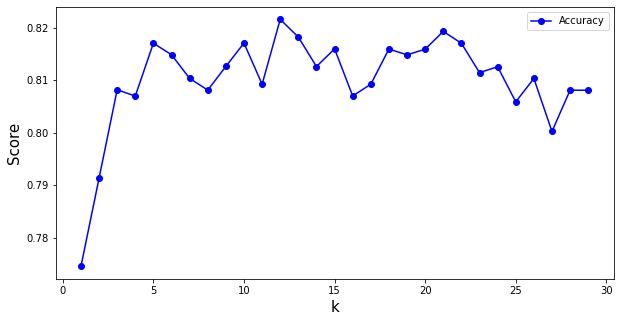

Melhor k: 21
Accuracy KNN: 0.8314606741573034


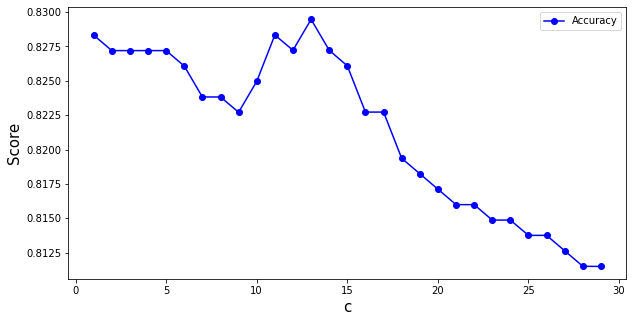

Melhor c: 13
Accuracy SVM: 0.7865168539325843


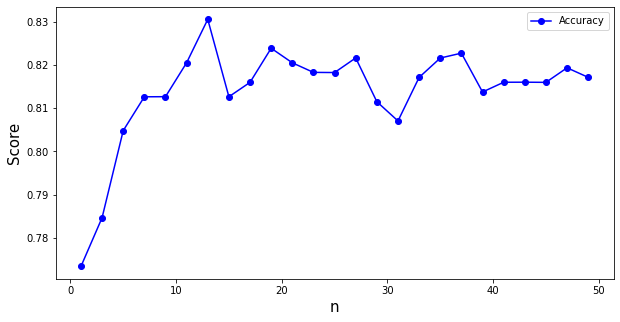

Melhor n: 7
Accuracy Floresta aleatoria: 0.8426966292134831


In [37]:
#Usando método de seleção validação cruzada

    # modelo KNN

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#cv = KFold(n_splits=10)
# enumerate the splits and summarize the distributions
mauc = []
macc = []
vk = []
for k in range(1, 30):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vk.append(k)
    #print('k:', k)
    #print('Average accuracy:', np.mean(vacc))
    #print('Average AUC:', np.mean(vauc))
best_k = np.argmax(mauc)+1

plt.figure(figsize=(10,5))
plt.plot(vk, macc, '-bo', label = 'Accuracy')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()
print('Melhor k:', best_k,)
print('Accuracy KNN:', accuracy_score(y_test, y_pred))


    #modelo SVM

from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#cv = KFold(n_splits=10)
# enumerate the splits and summarize the distributions
mauc = []
macc = []
vc = []
for c in range(1, 30):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = SVC(C = c, gamma = 'auto')
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vc.append(c)
    #print('k:', k)
    #print('Average accuracy:', np.mean(vacc))
    #print('Average AUC:', np.mean(vauc))
best_c = np.argmax(mauc)+1

plt.figure(figsize=(10,5))
plt.plot(vc, macc, '-bo', label = 'Accuracy')
plt.xlabel('c', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()
print('Melhor c:', best_c,)
print('Accuracy SVM:', accuracy_score(y_test, y_pred))


    #modelo floresta aleatoria
    
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#cv = KFold(n_splits=10)
# enumerate the splits and summarize the distributions
mauc = []
macc = []
vn = []
for n in range(1, 50,2):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = RandomForestClassifier(n_estimators=n)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vn.append(n)
best_n = np.argmax(mauc)+1
plt.figure(figsize=(10,5))
plt.plot(vn, macc, '-bo', label = 'Accuracy')
plt.xlabel('n', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()
print('Melhor n:', best_n,)
print('Accuracy Floresta aleatoria:', accuracy_score(y_test, y_pred))